In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

In [2]:
import requests
import math
import time
import argparse
import threading

node = '178.238.236.94'
nthreads = 10

def blocks_reader(seq_from, seq_to, index):
    print (seq_from, seq_to)
    thread_blocks[index] = requests.get('http://%s:6869/blocks/seq/%d/%d' % (node, seq_from, seq_to)).json()

In [3]:
max_days = -1
max_assets = -1
ndays = 0
count = 0
last = requests.get('http://' + node + ':6869/blocks/height').json()['height']
prevdate = ''
asset_txs={}
block_with_first_asset = 236967

data = pd.DataFrame()
args = {}


In [4]:
try:
    
    for n in range(int(math.ceil((last - block_with_first_asset) / (nthreads * 100)) + 1)):
        print n
        thread_blocks = []
        thread=[]
        for t in range(nthreads):
            thread_blocks.append('')
            thread.append(threading.Thread(target=blocks_reader, args=(max(1, last - (n + 1) * (nthreads * 100) + t*100 + 1), last - n * (nthreads * 100) - ((nthreads * 100) - 100) + t*100, t)))
            thread[t].start()
        blocks=[]
        for t in range(nthreads):
            thread[t].join()
            blocks = blocks + thread_blocks[t]
        for block in reversed(blocks):
            txs = block['transactions']
            for tx in reversed(txs):
                date = time.strftime('%m/%d/%Y', time.gmtime(tx['timestamp']/1000.))
                if date!=prevdate:
                    if ndays == max_days:
                        raise
                    ndays +=1
                prevdate = date

                if tx['type']==3:
                    txdata = pd.DataFrame.from_dict(tx, orient='index').transpose()
                    data = data.append(txdata, ignore_index=True)
                    
#                     print (tx)
                    if count == max_assets:
                        raise
                    issue_time = time.strftime('%m/%d/%Y %H:%M:%S', time.gmtime(tx['timestamp']/1000.))
                    issuer = tx['sender']
                    assetid = tx['assetId']
                    name = tx['name'][:20].encode('ascii', 'ignore')
                    description = tx['description'][:40].encode('ascii', 'ignore').replace('\n',' ')
                    qt = tx['quantity']
                    dec = tx['decimals']
                    amount = '{:.{prec}f}'.format(qt / 10. ** dec, prec=dec)
                    if tx['assetId'] in asset_txs:
                        txcount = asset_txs[tx['assetId']]
                    else:
                        txcount = 0
                    if txcount > 0:
                        count += 1
                        print ("%6d  %-45s %-20s %24s" % (count, assetid, name, amount))
                elif tx['type']==4:
                    if tx['assetId'] in asset_txs:
                        asset_txs[tx['assetId']] += 1
                    else:
                        asset_txs[tx['assetId']] = 0

except:
    pass

0
(628247, 628346)
(628347, 628446)
(628447, 628546)
(628547, 628646)
(628647, 628746)
(628747, 628846)
 (628947, 629046)(629047, 629146)(628847, 628946)


 (629147, 629246)
     1  6Ha5AJzRwdcoNyeBxPq8i5yEMi4qcjJVUzCxWGrDueEJ  Hyphy                           337337337.000
     2  8jxBp662QaSwsirBHq34tkKLzWDZefPtC1DttDFncLVk  NoobCoin                        21000000.0000
     3  9fZxQToMvgaN9xAb3TuyYonk4xkBzGVTQKBJKvhoAjzb  RHANIOC                       100000.00000000
1
(627247, 627346)
(627347, 627446)
(627447, 627546)
(627547, 627646)
(627647, 627746)
(627747, 627846)
 (627947, 628046)(627847, 627946)

(628047, 628146)(628147, 628246)

     4  63GKy5AFUfFsZ3pxwMhPv7SPsuWA5YBNgY8x2E5hjpfH  Ecoin                       21000000.00000000
     5  ABckLvQzufbkdAd2JxUY7zM6ACLefeHuz6AmHVkSKSkE  HARPOON                        25000.00000000
     6  7KxLuow3r2orN7Z7BXsCwztP2uAYMLuGkccmbHaUakUK  Granitecoin                      9876543210.0
2
(626247, 626346)
(626347, 626446)
(626447, 626546)


In [5]:
data2 = data.set_index(['assetId'])
data2 = data

# data2['timestamp'] = pd.to_datetime((data2['timestamp']),unit='ns')
data2['amount'] = data2[['quantity']].apply(lambda x: x/10. ** data2['decimals']).astype(int)
data3 = data2[['name','amount','description','reissuable','id','sender']]

data3

,name,amount,description,reissuable,id,sender
0,DARF,454,Distributed Accounting Resource planning and F...,False,F19PvdxUoGY88oSaPVB4LbNKrTpBkfXmgBRxWr2Cv1xb,3PPwaxrYRKKjtUAYm6jcJHMhfZzhu9GrDTK
1,Digital Asset,1000000,Digital Asset is a blockchain token created on...,True,FhQmwXh3yLM6qfB4aoHw97babdyq1hK1FRWdyTC6WwEU,3P6UXvQgsGq8P4WkQxj1XE6wtPJMPCEGe4h
2,KiCoin,1000,Tokens of the ki-aikido club Hokusei (www.hoku...,True,GTeox2aNxUc8XBVfgugefJnMmg4gaggHjAC6krv2UNEB,3PQaGYxmMN3VBrmP88E59Pwpq4W5zPSNgox
3,Planetary Token,300000,Environmental and Social Benefit token on www....,True,7ibRV7a97Y7xwaw8ksAwApzRrfNAKFVndg3miFCeaBoY,3P5wPHDoF4btD3yc7LV2TKP2QjTHLKQEiZi
4,abu coin,21000000,the official coin of abu,False,CvfZTQmu984AT3oDoLzYoPnLhjQc8JbKugck21fgFx3C,3P6Eiw5LNGJbtb13N9yurcnhu88gsBekgvQ
5,abu coin,2100000,the official coin of avu,False,9JzA8pcbMtKBe1Dvw87ANNf2VH9ow8ue5U8LqbRJE3s,3P6Eiw5LNGJbtb13N9yurcnhu88gsBekgvQ
6,Foodcoin,247000000,Foodcoin allows yoy to exchange and choose the...,True,12KvJobvz9Q1CTCjjxGujCWkduuaAiVsp13Mia18WQY5,3PEn3Ct4QAQkikMGRKMwJSzQSLaZ7o59Wcq
7,Peñacoin,12000000,Hemos creado Peñacoin\nPeñacoin (~) la primera...,True,9NAshSiaNb9FVvkvVtSFBAp1xFUMaG1sSpLxnyaNfToH,3P9U9zvy3Lw6Ek7yGRVfsZCyPuFGsAWZ2V9
8,Barter,100000000,Token for a perpetual barter-travel money-less...,False,EDcULyP8iwCzyUKXYnJLzMjeEHn7egSBnxrZ8DzZLM8M,3P5AsEa8kC9GmLzGaA4XvMRzzyFuKd5Dab6
9,Hyphy,337337337,,False,6Ha5AJzRwdcoNyeBxPq8i5yEMi4qcjJVUzCxWGrDueEJ,3PETKN9QBnbVdoSkSUEegcbJUcDKmEtPaxG


In [6]:
data3.to_csv('assets.csv', encoding='utf-8')

In [7]:
categorical_columns = [c for c in data3.columns if data3[c].dtype.name == 'object']
numerical_columns   = [c for c in data3.columns if data3[c].dtype.name != 'object']
print categorical_columns
print numerical_columns

[u'name', u'description', u'reissuable', u'id', u'sender']
[u'amount']


In [8]:

data3[categorical_columns].describe()

,name,description,reissuable,id,sender
count,3841,3841,3841,3841,3841
unique,3462,3192,2,3841,2309
top,Bitcoin,,False,9SHkXtyNsCjcYV9pMmjt7PqoB7nizZPtKjyj6Bd2wGaB,3PKxiBKhfNFazixNqRuS9QHv8mVj3WNTVin
freq,18,453,2119,1,56


In [9]:
#конвертируем текстовые значения в числовые индексы

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
data_fit = data3

# Encoding the variable
data_fit = data3.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
# data_fit.apply(lambda x: d[x.name].transform(x))

# print d['pol'].transform('муж')
# print d['professiya'].inverse_transform(8)

data_fit[:4]


,name,amount,description,reissuable,id,sender
0,687,41,728,0,2966,2191
1,778,171,707,1,3151,444
2,1451,49,2474,1,3327,2243
3,2043,141,806,1,1296,398


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f950043cc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f94d3109b90>]], dtype=object)

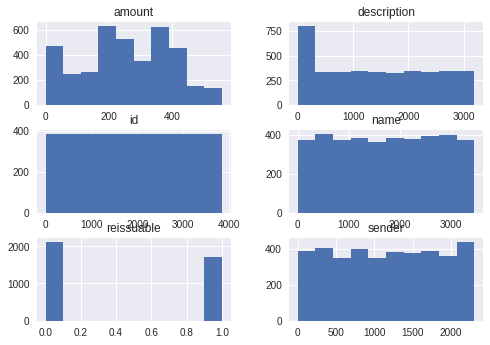

In [10]:
data_fit.hist()

# Тренеруем алгоритм

In [173]:
def predskazanie(data,chto=''):
    """
    Основная функция предсказаний, 
    Передаем столбцы и предсказываем значение
    """
    
    X = data.drop((chto), axis=1)  # Выбрасываем столбец 
    print data.shape

    y = data[chto]
    feature_names = X.columns
    print feature_names

    # подготавливаем выборку
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

    N_train, _ = X_train.shape 
    N_test,  _ = X_test.shape 
    print N_train, N_test

    # запускаем лес
    from sklearn import ensemble
    rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
    rf.fit(X_train, y_train)

    err_train = np.mean(y_train != rf.predict(X_train))
    err_test  = np.mean(y_test  != rf.predict(X_test))
    print 'Процент ошибки: ', err_train, err_test

    #выбираем важные
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Важность признаков по убыванию:")
    for f, idx in enumerate(indices):
        print("{:2d}. признак '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

    #график важных
    d_first = data.shape[1]-1
    plt.figure(figsize=(8, 8))
    plt.title("Важность признаков для предсказании: " + chto)
    plt.barh(range(d_first), importances[indices[:d_first]], align='center')
    plt.yticks(range(d_first), np.array(feature_names)[indices[:d_first]])
#     plt.xlim([-1, d_first]);
    
    return X


## Зависимость

(5380, 5)
Index([u'name', u'description', u'reissuable', u'sender'], dtype='object')
3766 1614
Процент ошибки:  0.00238980350505 0.248451053284
Важность признаков по убыванию:
 1. признак 'name ' (0.3425)
 2. признак 'sender' (0.3416)
 3. признак 'description' (0.2960)
 4. признак 'reissuable' (0.0199)


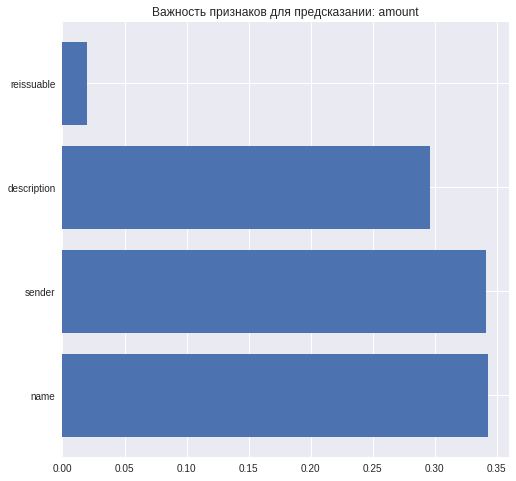

In [175]:
zavis = predskazanie(data_fit.drop(['id'], axis=1),chto='amount')

# ОБЩИЙ АНАЛИЗ ДАННЫХ

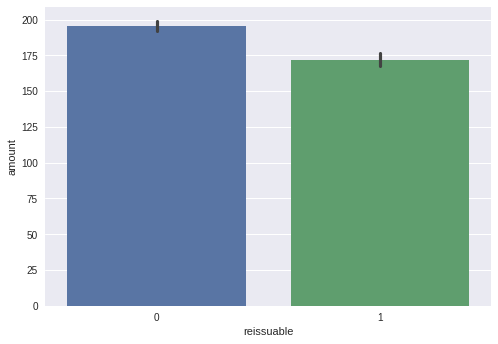

0 False
1 True


In [176]:
## Профессия и Зарплата

xxx = 'reissuable'
yyy = 'amount'

ax = sns.barplot(x=xxx, y=yyy, data=data_fit);
ax.set(xlabel='reissuable', ylabel='amount')
plt.show()

maxval = data_fit.loc[data_fit[xxx].idxmax()][xxx]

for i in range(maxval+1):
    print i, d[xxx].inverse_transform(i)